**这个Notebook需要dmg文件夹中文件, 其他函数在Notebook中定义.**

## Package Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg

## Define R, P, Poisson, Nonlinear Poisson

In [2]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
    sqrtoutputsize = int(np.sqrt(outputsize))
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def NonlinearPoisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))
    h = 1/(sqrtinputsize-1)
    KX = np.zeros([inputsize,inputsize+1])
    KY = np.zeros([inputsize+1,inputsize])
    for i in range(sqrtinputsize):
        for j in range(sqrtinputsize+1):
            KX[i][j] = a(j*h-0.5*h,i*h)
    for i in range(sqrtinputsize+1):
        for j in range(sqrtinputsize):
            KY[i][j] = a(j*h,i*h-0.5*h)
    OUTPUT = (gallery.nonlinearPoisson((sqrtinputsize,sqrtinputsize),KX,KY)).to_full()
    return OUTPUT

## Define Multigrid

In [3]:
def Multigrid_circle(inputsize, A_A, B, R_A, s, w, NUM_EPOCH):
    A = np.matrix(A_A)
    P = 4*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    for i in range(NUM_EPOCH):
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

## Define Spectral Radius Calculator

In [4]:
def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def rhoAuto(INPUT):
    R = INPUT[0]
    w = INPUT[1]
    P = 4*np.transpose(R)
    M = (w**(-1)) * np.diag(np.diag(A1))
    K = M - A1
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A1),P))),R),A1)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

## Define Optimizer

In [5]:
def optimizer_GD(inputsize, A, R, w, s, learning_rate):
    rhoold = rho(inputsize,A,4*np.transpose(R),R,w,s)
    INPUT = [R,w]
    rhoGra = grad(rhoAuto)
    delta = rhoGra(INPUT)
    R -= learning_rate*delta[0]
    w -= learning_rate*delta[1]
    rhonew = rho(inputsize,A,4*np.transpose(R),R,w,s)
    return R, w, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            P = 4*np.transpose(R)
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhonew <= rhoold and i<100:
        Rnew, wnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate)
        R = Rnew
        Radius.append(Rnew)
        w = wnew
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

In [6]:
finegridsize = 5
s = 1
w = 2/3
MAX_ITER = 50

# Experiment (with large e1, e2, e3, e4, e5)

选取比较大的参数, a函数频率较小

In [7]:
e = 0.001
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)

**Plot $a(x,y)$**

In [8]:
inputsize = (2**finegridsize-1)**2
inputsize = int(inputsize)
sqrtinputsize = int(np.sqrt(inputsize))
outputsize = int((2**(np.log2(np.sqrt(inputsize)+1)-1)-1)**2)
sqrtoutputsize = int(np.sqrt(outputsize))
h = 1/(sqrtinputsize-1)
A0 = Poisson(inputsize)
A1 = NonlinearPoisson(inputsize)
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
R = Restriction(inputsize)
P = 4*np.transpose(R)

**Plot A0, A1**

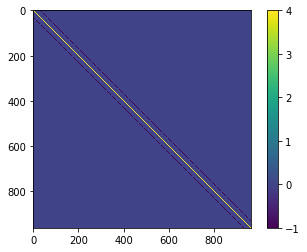

In [9]:
plt.imshow(A0)
plt.colorbar()

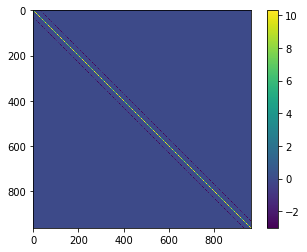

In [10]:
plt.imshow(A1)
plt.colorbar()


## GMM

**Calculate Result and Residual**

In [11]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1, RightF, R, s, w, MAX_ITER)

Residual = 73.31086614470136
Interation = 0
Residual = 14.266236661247572
Interation = 1
Residual = 4.174851312782605
Interation = 2
Residual = 1.4164383924236754
Interation = 3
Residual = 0.535994494222845
Interation = 4
Residual = 0.21912967485478693
Interation = 5
Residual = 0.0941733699657634
Interation = 6
Residual = 0.04177321258561131
Interation = 7
Residual = 0.018920112506204057
Interation = 8
Residual = 0.008694885174703411
Interation = 9
Residual = 0.0040386390594842414
Interation = 10
Residual = 0.0018912182286032763
Interation = 11
Residual = 0.0008913237848478566
Interation = 12
Residual = 0.00042226688161189587
Interation = 13
Residual = 0.00020091404985631036
Interation = 14
Residual = 9.594371018796788e-05
Interation = 15
Residual = 4.596038541060874e-05
Interation = 16
Residual = 2.20768309640853e-05
Interation = 17
Residual = 1.0630024788402596e-05
Interation = 18
Residual = 5.129316165767599e-06
Interation = 19
Residual = 2.479784861941358e-06
Interation = 20
Residu

In [12]:
np.linalg.norm(Ureal - GMM_U,np.inf)

3.253451530174612

**Plot Result**

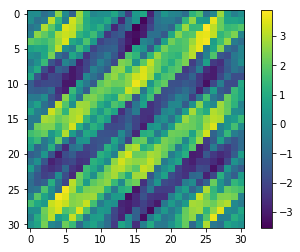

In [13]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

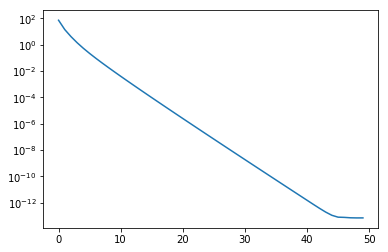

In [14]:
plt.semilogy(GMM_Res)

**Calculate Spectral Radius**

In [15]:
GMM_Radius = rho(inputsize,A1,4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.5148857493761246


## AMG

**Define Solver and Solve**

In [16]:
amg_solver = pyamg.classical.classical.ruge_stuben_solver(A1,max_levels = 2)
pyamg.relaxation.smoothing.change_smoothers(amg_solver,presmoother=("jacobi", {"omega": w, "iterations": s}),postsmoother=("jacobi", {"omega": w, "iterations": s}))
AMG_Res = []
print(amg_solver)
AMG_U= amg_solver.solve(RightF, maxiter = MAX_ITER, tol=0, residuals=AMG_Res)

multilevel_solver
Number of Levels:     2
Operator Complexity:  1.872
Grid Complexity:      1.501
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0          961         4681 [53.42%]
    1          481         4081 [46.58%]



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pyamg/classical/classical.py:98: SparseEfficiencyWarning: Implicit conversion of A to CSR
  SparseEfficiencyWarning)


**Plot Result**

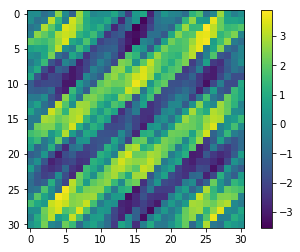

In [17]:
plt.imshow(AMG_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

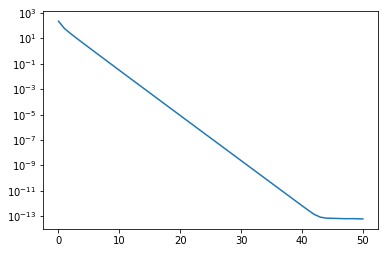

In [18]:
plt.semilogy(AMG_Res)

## DMM with full R optimization

**Optimize R, P, $\omega$**

learning_rate是梯度下降时步长, step_length是每一个M之间的距离, 两者都必须非常小, 不然会出现不好的结果.

In [19]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1, Restriction(inputsize),  2/3, s, learning_rate = 1e-1,accept_radius = GMM_Radius,step_length = 1e-1)

======Section 1======
L = 0.2
rho = 0.41451867952591337
Decrease the step_length, learning_rate and Restart!!
step_length = 0.010000000000000002
learning_rate = 0.010000000000000002
rhonew = 0.8083414779635756
L = 0.020000000000000004
rho = 0.44961737485817277
L = 0.030000000000000006
rho = 0.4452663934349186
L = 0.04000000000000001
rho = 0.44104352574627503
L = 0.05000000000000001
rho = 0.4369337108057323
L = 0.06000000000000001
rho = 0.43301833342046087
L = 0.07
rho = 0.4295906447438537
L = 0.08000000000000002
rho = 0.43366795602668684
Decrease the step_length, learning_rate and Restart!!
step_length = 0.0010000000000000002
learning_rate = 0.0010000000000000002
rhonew = 0.6297981339487317
L = 0.0020000000000000005
rho = 0.4536296109921893
L = 0.003000000000000001
rho = 0.45317911112182346
L = 0.004000000000000001
rho = 0.4527299441436264
L = 0.005000000000000001
rho = 0.4522820784022172
L = 0.006000000000000001
rho = 0.4518354908364313
L = 0.007000000000000001
rho = 0.451390164200772

L = 0.10700000000000008
rho = 0.4122093504529095
L = 0.10800000000000008
rho = 0.4118617840639681
L = 0.10900000000000008
rho = 0.411514926399565
L = 0.11000000000000008
rho = 0.41116877334571444
L = 0.11100000000000008
rho = 0.41082332082423867
L = 0.11200000000000009
rho = 0.41047856479272615
L = 0.11300000000000009
rho = 0.41013450124448336
L = 0.11400000000000009
rho = 0.4097911262084799
L = 0.11500000000000009
rho = 0.40944843574928674
L = 0.11600000000000009
rho = 0.40910642596700764
L = 0.11700000000000009
rho = 0.4087650929972065
L = 0.11800000000000009
rho = 0.4084244330108271
L = 0.11900000000000009
rho = 0.4080844422141105
L = 0.12000000000000009
rho = 0.40774511684850484
L = 0.1210000000000001
rho = 0.40740645319057345
L = 0.1220000000000001
rho = 0.40706844755189703
L = 0.1230000000000001
rho = 0.40673109627897386
L = 0.1240000000000001
rho = 0.40639439575311576
L = 0.12500000000000008
rho = 0.4060583423903414
L = 0.12600000000000008
rho = 0.4057229326412678
L = 0.12700000

L = 0.22600000000000017
rho = 0.37720509591815693
L = 0.22700000000000017
rho = 0.3775068632855276
L = 0.22800000000000017
rho = 0.3779189163787567
L = 0.22900000000000018
rho = 0.3784450041616072
L = 0.23000000000000018
rho = 0.3790840525619022
L = 0.23100000000000018
rho = 0.3798301500440108
L = 0.23200000000000018
rho = 0.38067322357411987
L = 0.23300000000000018
rho = 0.3816001890594947
L = 0.23400000000000018
rho = 0.38259625788298224
L = 0.23500000000000018
rho = 0.383646112391286
L = 0.23600000000000018
rho = 0.3847347792791689
L = 0.23700000000000018
rho = 0.38584815711845993
L = 0.23800000000000018
rho = 0.3869732438312922
L = 0.23900000000000018
rho = 0.3880981510038241
L = 0.24000000000000019
rho = 0.38921199839163817
L = 0.2410000000000002
rho = 0.39030477300194333
L = 0.2420000000000002
rho = 0.3913672250918343
L = 0.2430000000000002
rho = 0.3923908594662944
L = 0.2440000000000002
rho = 0.39336805685747045
L = 0.2450000000000002
rho = 0.39429231896459993
L = 0.246000000000

L = 0.34600000000000025
rho = 0.4070059304284894
L = 0.34700000000000025
rho = 0.40703756528029433
L = 0.34800000000000025
rho = 0.40706884386185227
L = 0.34900000000000025
rho = 0.4070997694025061
L = 0.35000000000000026
rho = 0.4071303450742995
L = 0.35100000000000026
rho = 0.40716057399361466
L = 0.35200000000000026
rho = 0.40719045922274305
L = 0.35300000000000026
rho = 0.407220003771403
L = 0.35400000000000026
rho = 0.40724921059820185
L = 0.35500000000000026
rho = 0.40727808261204845
L = 0.35600000000000026
rho = 0.4073066226735118
L = 0.35700000000000026
rho = 0.40733483359613765
L = 0.35800000000000026
rho = 0.40736271814771663
L = 0.35900000000000026
rho = 0.4073902790515133
L = 0.36000000000000026
rho = 0.40741751898745043
L = 0.36100000000000027
rho = 0.4074444405932569
L = 0.36200000000000027
rho = 0.407471046465578
L = 0.36300000000000027
rho = 0.40749733916104974
L = 0.36400000000000027
rho = 0.40752332119733736
L = 0.36500000000000027
rho = 0.4075489950541421
L = 0.36600

L = 0.46500000000000036
rho = 0.4088776801247281
L = 0.46600000000000036
rho = 0.40888106350498427
L = 0.46700000000000036
rho = 0.4088842913248906
L = 0.46800000000000036
rho = 0.4088873646232875
L = 0.46900000000000036
rho = 0.40889028443570197
L = 0.47000000000000036
rho = 0.4088930517944371
L = 0.47100000000000036
rho = 0.4088956677286566
L = 0.47200000000000036
rho = 0.4088981332644792
L = 0.47300000000000036
rho = 0.40890044942505743
L = 0.47400000000000037
rho = 0.40890261723066407
L = 0.47500000000000037
rho = 0.4089046376987774
L = 0.47600000000000037
rho = 0.40890651184415944
L = 0.47700000000000037
rho = 0.4089082406789392
L = 0.47800000000000037
rho = 0.4089098252126903
L = 0.47900000000000037
rho = 0.40891126645251014
L = 0.48000000000000037
rho = 0.40891256540309684
L = 0.48100000000000037
rho = 0.40891372306682416
L = 0.4820000000000004
rho = 0.40891474044381987
L = 0.4830000000000004
rho = 0.40891561853203356
L = 0.4840000000000004
rho = 0.40891635832731565
L = 0.485000

L = 0.5850000000000004
rho = 0.40845091621422547
L = 0.5860000000000004
rho = 0.4084426726592837
L = 0.5870000000000004
rho = 0.4084343923409199
L = 0.5880000000000004
rho = 0.4084260763099733
L = 0.5890000000000004
rho = 0.4084177256195908
L = 0.5900000000000004
rho = 0.408409341325249
L = 0.5910000000000004
rho = 0.40840092448476634
L = 0.5920000000000004
rho = 0.40839247615832364
L = 0.5930000000000004
rho = 0.40838399740848
L = 0.5940000000000004
rho = 0.40837548930018863
L = 0.5950000000000004
rho = 0.4083669529008104
L = 0.5960000000000004
rho = 0.40835838928012924
L = 0.5970000000000004
rho = 0.40834979951036626
L = 0.5980000000000004
rho = 0.4083411846661931
L = 0.5990000000000004
rho = 0.40833254582474177
L = 0.6000000000000004
rho = 0.4083238840656203
L = 0.6010000000000004
rho = 0.40831520047091985
L = 0.6020000000000004
rho = 0.4083064961252272
L = 0.6030000000000004
rho = 0.408297772115634
L = 0.6040000000000004
rho = 0.4082890295317459
L = 0.6050000000000004
rho = 0.40828

L = 0.7050000000000005
rho = 0.40751375394933337
L = 0.7060000000000005
rho = 0.40750923513007337
L = 0.7070000000000005
rho = 0.4075048196603791
L = 0.7080000000000005
rho = 0.4075005087145797
L = 0.7090000000000005
rho = 0.40749630346337284
L = 0.7100000000000005
rho = 0.4074922050736853
L = 0.7110000000000005
rho = 0.4074882147085342
L = 0.7120000000000005
rho = 0.40748433352688457
L = 0.7130000000000005
rho = 0.4074805626835046
L = 0.7140000000000005
rho = 0.4074769033288229
L = 0.7150000000000005
rho = 0.4074733566087839
L = 0.7160000000000005
rho = 0.40746992366470053
L = 0.7170000000000005
rho = 0.40746660563310777
L = 0.7180000000000005
rho = 0.4074634036456142
L = 0.7190000000000005
rho = 0.40746031882875533
L = 0.7200000000000005
rho = 0.40745735230383906
L = 0.7210000000000005
rho = 0.4074545051867994
L = 0.7220000000000005
rho = 0.4074517785880442
L = 0.7230000000000005
rho = 0.4074491736123022
L = 0.7240000000000005
rho = 0.40744669135847045
L = 0.7250000000000005
rho = 0.

L = 0.8250000000000006
rho = 0.4079813227460401
L = 0.8260000000000006
rho = 0.40799537963205434
L = 0.8270000000000006
rho = 0.4080096156646377
L = 0.8280000000000006
rho = 0.4080240306840453
L = 0.8290000000000006
rho = 0.4080386245165994
L = 0.8300000000000006
rho = 0.4080533969747693
L = 0.8310000000000006
rho = 0.40806834785725504
L = 0.8320000000000006
rho = 0.40808347694907426
L = 0.8330000000000006
rho = 0.4080987840216505
L = 0.8340000000000006
rho = 0.4081142688329075
L = 0.8350000000000006
rho = 0.40812993112736373
L = 0.8360000000000006
rho = 0.40814577063623075
L = 0.8370000000000006
rho = 0.40816178707751566
L = 0.8380000000000006
rho = 0.4081779801561249
L = 0.8390000000000006
rho = 0.40819434956397155
L = 0.8400000000000006
rho = 0.40821089498008495
L = 0.8410000000000006
rho = 0.4082276160707238
L = 0.8420000000000006
rho = 0.4082445124894906
L = 0.8430000000000006
rho = 0.4082615838774506
L = 0.8440000000000006
rho = 0.4082788298632508
L = 0.8450000000000006
rho = 0.4

L = 0.9450000000000007
rho = 0.41081150007165235
L = 0.9460000000000007
rho = 0.41084305782195574
L = 0.9470000000000007
rho = 0.4108747137280958
L = 0.9480000000000007
rho = 0.4109064669483293
L = 0.9490000000000007
rho = 0.4109383166432749
L = 0.9500000000000007
rho = 0.41097026197599296
L = 0.9510000000000007
rho = 0.4110023021120659
L = 0.9520000000000007
rho = 0.4110344362196742
L = 0.9530000000000007
rho = 0.41106666346967236
L = 0.9540000000000007
rho = 0.4110989830356632
L = 0.9550000000000007
rho = 0.4111313940940693
L = 0.9560000000000007
rho = 0.41116389582420365
L = 0.9570000000000007
rho = 0.4111964874083386
L = 0.9580000000000007
rho = 0.41122916803177284
L = 0.9590000000000007
rho = 0.4112619368828969
L = 0.9600000000000007
rho = 0.4112947931532569
L = 0.9610000000000007
rho = 0.4113277360376163
L = 0.9620000000000007
rho = 0.4113607647340175
L = 0.9630000000000007
rho = 0.41139387844383946
L = 0.9640000000000007
rho = 0.41142707637185594
L = 0.9650000000000007
rho = 0.4

rho = 0.4121212986386918
rho = 0.4121153903512054
rho = 0.4121094859617428
rho = 0.4121035854639166
======End======


**Calculate Result and Residual**

In [20]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1, RightF, Rnew, s, wnew, MAX_ITER)

Residual = 82.06060611263962
Interation = 0
Residual = 12.221891288256039
Interation = 1
Residual = 2.7395390714712904
Interation = 2
Residual = 0.8552146646464723
Interation = 3
Residual = 0.30408420074933934
Interation = 4
Residual = 0.11199800797120439
Interation = 5
Residual = 0.04169977736798243
Interation = 6
Residual = 0.015597079100316467
Interation = 7
Residual = 0.0058488735679484045
Interation = 8
Residual = 0.002197265658871205
Interation = 9
Residual = 0.0008266574839319455
Interation = 10
Residual = 0.000311409209598119
Interation = 11
Residual = 0.00011745329774936378
Interation = 12
Residual = 4.43514342965821e-05
Interation = 13
Residual = 1.6766655220508592e-05
Interation = 14
Residual = 6.345588611330788e-06
Interation = 15
Residual = 2.4042271287756255e-06
Interation = 16
Residual = 9.119033319335661e-07
Interation = 17
Residual = 3.4624496224588515e-07
Interation = 18
Residual = 1.3160459262012825e-07
Interation = 19
Residual = 5.007294381228614e-08
Interation = 20

In [21]:
np.linalg.norm(Ureal - DMM_U,np.inf)

3.253451530174611

**Plot Result**

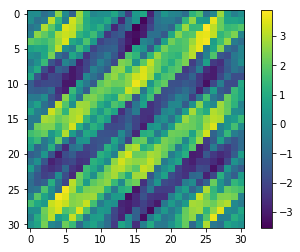

In [22]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

**Plot Residual**

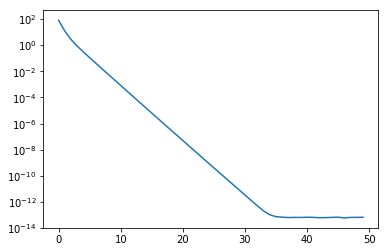

In [23]:
plt.semilogy(DMM_Res)

**Calculate Spectral Radius**

In [24]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.4121035854639166


R under log10(abs())


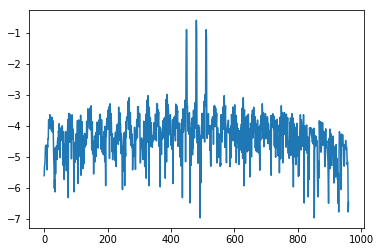

In [25]:
print("R under log10(abs())")
plt.plot(np.log10(np.abs(Rnew))[round(0.5*outputsize)][:])

## DMM with nine point scheme optimizer

**Build the stiff matrix**

In [26]:
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A = gallery.nonlinearPoisson((n,n), kx, ky)

In [27]:
PR_stencil_type = "m9p"
gmm = dgmg.DeepMG(A, PR_stencil_type=PR_stencil_type, max_levels=num_levels)
num_iter = 2500
step_size = 1e-4
opt_par = gmm.optimize(num_iter=num_iter, step_size=step_size)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return lambda g: g[idxs]


Iteration 100/2500
Upper bound estimation = 0.277754391775025
Iteration 200/2500
Upper bound estimation = 0.2662919397650224
Iteration 300/2500
Upper bound estimation = 0.2555349737674192
Iteration 400/2500
Upper bound estimation = 0.240337135768763
Iteration 500/2500
Upper bound estimation = 0.22438352520419624
Iteration 600/2500
Upper bound estimation = 0.2115861374482852
Iteration 700/2500
Upper bound estimation = 0.2050937521762534
Iteration 800/2500
Upper bound estimation = 0.19748560300505438
Iteration 900/2500
Upper bound estimation = 0.18879589555844756
Iteration 1000/2500
Upper bound estimation = 0.18362927094932005
Iteration 1100/2500
Upper bound estimation = 0.1797179347511006
Iteration 1200/2500
Upper bound estimation = 0.1718374398119008
Iteration 1300/2500
Upper bound estimation = 0.166143277914234
Iteration 1400/2500
Upper bound estimation = 0.16511649101508258
Iteration 1500/2500
Upper bound estimation = 0.1609092112585408
Iteration 1600/2500
Upper bound estimation = 0.

In [28]:
print(gmm)
convergence = gmm.get_optimizer_convergence()
conv_time = gmm.get_optimization_time()
gmm.update_prd(opt_par)
DMM_rho = gmm.compute_rho()
print("DMM rho = {}".format(DMM_rho))

Dimension of matrix A for levels:
Level = 0, dimension = (15, 15)
Level = 1, dimension = (31, 31)



ArpackNoConvergence: ARPACK error -1: No convergence (9611 iterations, 0/1 eigenvectors converged) [ARPACK error -14: DNAUPD  did not find any eigenvalues to sufficient accuracy.]

[1.48682407e+01 1.64614254e+00 2.92848038e-01 3.83032219e-02
 3.26010064e-03 2.48624492e-04 2.71577404e-05 3.23295473e-06
 3.43015683e-07 3.76453980e-08 4.55636182e-09 5.50941226e-10
 6.55245604e-11 7.96732246e-12 9.79328212e-13 1.29434219e-13
 5.89051466e-14 5.46459816e-14 4.87676199e-14 4.66941194e-14
 5.17017662e-14 4.56049086e-14 4.67869144e-14 4.98558164e-14
 4.87604331e-14 4.95389661e-14 4.73614457e-14 5.22206483e-14
 5.08792141e-14 4.79350693e-14 4.85079084e-14 4.68840146e-14
 4.67476406e-14 4.82790374e-14 5.37669940e-14 4.71521298e-14
 5.07273968e-14 5.22959406e-14 4.67445057e-14 4.88102219e-14
 4.90482976e-14 4.96253228e-14 4.98742191e-14 4.53852457e-14
 4.79942105e-14 4.63122197e-14 4.63668640e-14 4.58077283e-14
 4.84516994e-14 5.39784841e-14]


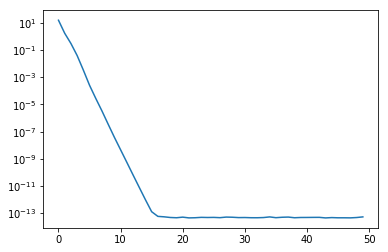

In [29]:
x = gmm.solve(RightF, np.random.randn(A.shape), tol=0, max_iter=50)
print(gmm.get_gmg_convergence())
plt.semilogy(gmm.get_gmg_convergence())

In [30]:
np.linalg.norm(Ureal - x,np.inf)

3.25345153017461

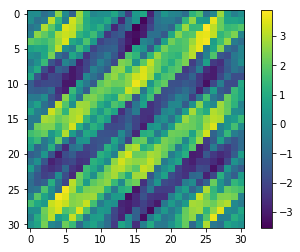

In [31]:
x = x.reshape(A.dim)
plt.imshow(x)
plt.colorbar()

In [32]:
np.set_printoptions(threshold=np.inf)
print("omega = {}".format(opt_par[2]))

omega = 0.8033439181542217


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log10
  return f_raw(*args, **kwargs)


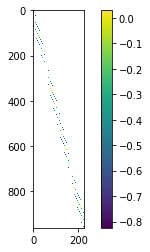

In [33]:
P = opt_par[0][0]
k = int(2**(np.log2(n+1)-1)-1) 
P_Matrix = np.zeros([n**2,k**2])
for i in range(k):
    for j in range(k):
        C = P[i][j]
        for l in range(3):
            for m in range(3):
                P_Matrix[n*(2*i+l)+(2*j+m)][k*i+j] = C[l][m]
plt.imshow(np.log10(np.abs(P_Matrix)))
plt.colorbar()

P under log10(abs())


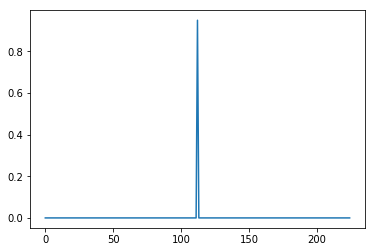

In [34]:
print("P under log10(abs())")
plt.plot(P_Matrix[round(0.5*inputsize)][:])

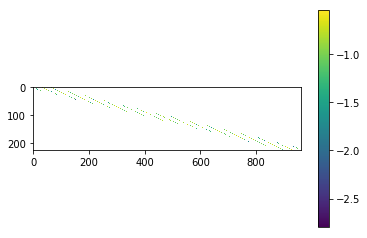

In [35]:
R = opt_par[1][0]
R_Matrix = np.zeros([k**2,n**2])
for i in range(k):
    for j in range(k):
        C = R[i][j]
        for l in range(3):
            for m in range(3):
                R_Matrix[k*i+j][n*(2*i+l)+(2*j+m)] = C[l][m]
plt.imshow(np.log10(np.abs(R_Matrix)))
plt.colorbar()

R under log10(abs())


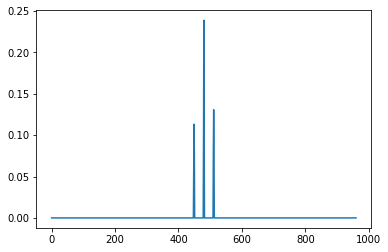

In [36]:
print("R under log10(abs())")
plt.plot(R_Matrix[:][round(0.5*outputsize)])

## Compare

Text(0, 0.5, 'Residual')

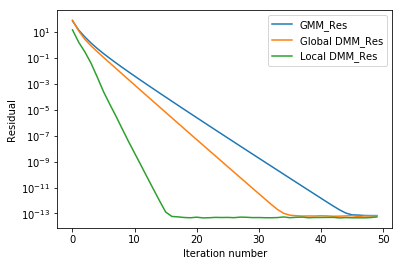

In [37]:
plt.semilogy(GMM_Res, label = 'GMM_Res')
plt.semilogy(DMM_Res, label = 'Global DMM_Res')
plt.semilogy(gmm.get_gmg_convergence(), label = 'Local DMM_Res')
plt.legend(loc='upper right')
plt.xlabel('Iteration number')
plt.ylabel('Residual')